# Code to generate random incompressible flow snap-shots

In [151]:
import numpy as np
import scipy as sp1
import scipy.ndimage as sp
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

## Parameters

In [152]:
GridSize = 100
SmoothenSigma = 20
MaxShift = 3

## Random seed-field

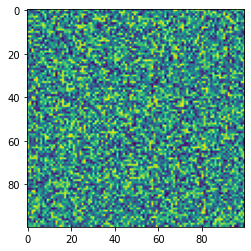

In [153]:
RandomField = np.random.rand( GridSize , GridSize )

plt.imshow( RandomField )
plt.show()

## Smooth the random field

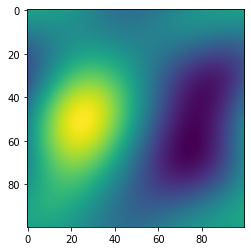

In [154]:
StreamFunction = sp.gaussian_filter( RandomField , sigma=SmoothenSigma , mode='wrap' )

plt.imshow( StreamFunction )
plt.show()

## Flow from stream function: $\psi$
### For any smooth random scalar field $\psi$, the velocity field is given by
### $ \vec{u} = \nabla \times \psi $
### such that, $\nabla . \vec{u} = 0$, i.e. incompressible.

## Calculation of velocity field

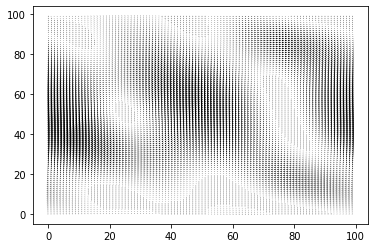

In [155]:
Vx =  np.gradient( StreamFunction , axis=0 )
Vy = -np.gradient( StreamFunction , axis=1 )

plt.quiver( Vx , Vy , units='width' )
plt.show()

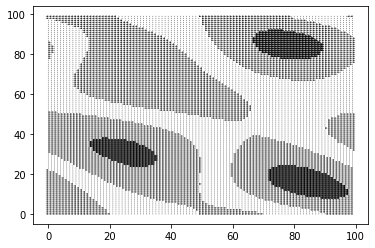

In [156]:
MagV = np.sqrt( Vx * Vx + Vy * Vy )
MaxMagV = np.max( MagV )

Vx = np.round( Vx * MaxShift / MaxMagV )
Vy = np.round( Vy * MaxShift / MaxMagV )
Vy = 0 * Vy

plt.quiver( Vx , Vy , units='width' )
plt.show()

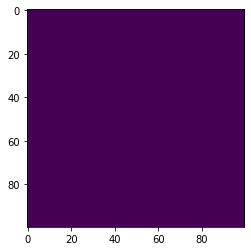

In [157]:
plt.imshow(Vy)

In [158]:
Frame1 = np.random.rand( GridSize , GridSize )
Frame2 = np.copy( Frame1 )

for XShift in range(-MaxShift , MaxShift):
    for YShift in range(-MaxShift , MaxShift):
        I = ((Vx<XShift) * (Vy==YShift))

        OverlayFrame = np.random.rand( GridSize , GridSize )

        Frame1 = Frame1 * (1-I) + OverlayFrame * I

        I = np.roll( I , XShift , axis=0 )
        I = np.roll( I , YShift , axis=1 )

        OverlayFrame = np.roll( OverlayFrame , YShift , axis=0 )
        OverlayFrame = np.roll( OverlayFrame , XShift , axis=1 )

        Frame2 = Frame2 * (1-I) + OverlayFrame * I

In [159]:
Frame1 = np.random.rand( GridSize , GridSize )
Frame2 = np.copy( Frame1 )

YShift = 0

for XShift in range(-MaxShift , MaxShift):
    I = ((Vx>XShift))

    OverlayFrame = np.random.rand( GridSize , GridSize )

    Frame1 = Frame1 * (1-I) + OverlayFrame * I

    I = np.roll( I , XShift , axis=0 )
    I = np.roll( I , YShift , axis=1 )

    OverlayFrame = np.roll( OverlayFrame , YShift , axis=0 )
    OverlayFrame = np.roll( OverlayFrame , XShift , axis=1 )

    Frame2 = Frame2 * (1-I) + OverlayFrame * I

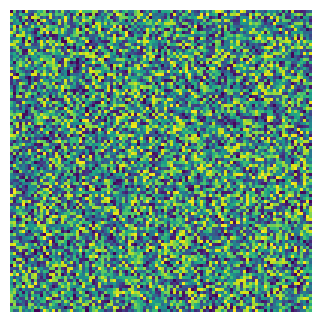

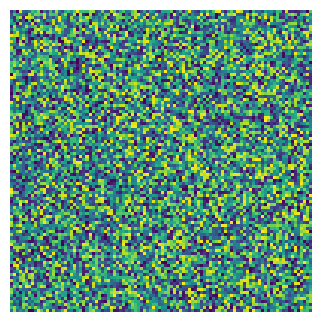

In [160]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Frame1 )
plt.axis('off')
plt.savefig('Frame1.png',bbox_inches='tight',transparent=False,pad_inches = 0)

fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Frame2 )
plt.axis('off')
plt.savefig('Frame2.png',bbox_inches='tight',transparent=False,pad_inches = 0)

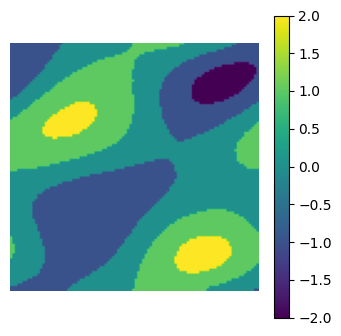

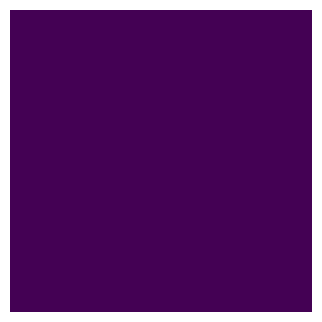

In [161]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Vx )
plt.colorbar()
plt.axis('off')
plt.savefig('Vx.png',bbox_inches='tight',transparent=False,pad_inches = 0)

fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Vy )
plt.axis('off')
plt.savefig('Vy.png',bbox_inches='tight',transparent=False,pad_inches = 0)

In [162]:
DataSize = 50000
WindowSize = 5
LabelSize = 2*MaxShift + 1

Height, Width = Frame1.shape
HalfWindowSize = int( WindowSize/2 )

TrainImages = np.zeros([DataSize,WindowSize,WindowSize,2])
TrainLabels = np.zeros([DataSize,LabelSize])

In [163]:
for i in range(DataSize):
    XShift = int( np.floor( np.random.rand(1) * Width ) )
    YShift = int( np.floor( np.random.rand(1) * Height ) )

    XXShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift

    ShiftedFrame1 = np.roll( Frame1 , (YShift,XShift) , axis=(0,1) )
    ShiftedFrame2 = np.roll( Frame1 , (YShift,XShift+XXShift) , axis=(0,1) )

    TrainImages[i,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
    TrainImages[i,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

    TrainLabels[i,XXShift + MaxShift] = 1

In [164]:
TestImages = np.zeros([DataSize,WindowSize,WindowSize,2])
TestLabels = np.zeros([DataSize,LabelSize])

In [165]:
for i in range(DataSize):
    XShift = int( np.floor( np.random.rand(1) * Width ) )
    YShift = int( np.floor( np.random.rand(1) * Height ) )

    XXShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift

    ShiftedFrame1 = np.roll( Frame1 , (YShift,XShift) , axis=(0,1) )
    ShiftedFrame2 = np.roll( Frame1 , (YShift,XShift+XXShift) , axis=(0,1) )

    TestImages[i,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
    TestImages[i,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

    TestLabels[i,XXShift + MaxShift] = 1

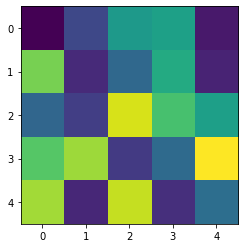

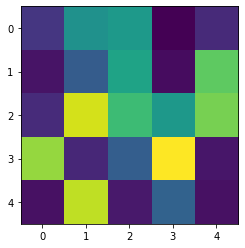

0.0


In [166]:
plt.imshow(TrainImages[10,:,:,0])
plt.show()

plt.imshow(TrainImages[10,:,:,1])
plt.show()

print(TrainLabels[10,0])

In [167]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(WindowSize, WindowSize, 2)))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense( 2*MaxShift+1 ))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                3264      
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                                 
Total params: 3,719
Trainable params: 3,719
Non-trainable params: 0
_________________________________________________________________


In [168]:
model.compile( optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

history = model.fit(TrainImages, TrainLabels, epochs=20, 
                    validation_data=(TestImages, TestLabels))

Epoch 1/20
3125/3125 [==============================] - 5s 1ms/step - loss: 0.0866 - accuracy: 0.6136 - val_loss: 0.0529 - val_accuracy: 0.9271
Epoch 2/20
3125/3125 [==============================] - 5s 1ms/step - loss: 0.0438 - accuracy: 0.9659 - val_loss: 0.0383 - val_accuracy: 0.9900
Epoch 3/20
3125/3125 [==============================] - 5s 1ms/step - loss: 0.0345 - accuracy: 0.9952 - val_loss: 0.0321 - val_accuracy: 0.9973
Epoch 4/20
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0299 - accuracy: 0.9991 - val_loss: 0.0301 - val_accuracy: 0.9993
Epoch 5/20
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0278 - accuracy: 0.9996 - val_loss: 0.0269 - val_accuracy: 0.9997
Epoch 6/20
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0267 - accuracy: 0.9998 - val_loss: 0.0277 - val_accuracy: 0.9998
Epoch 7/20
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0259 - accuracy: 0.9999 - val_loss: 0.0259 - val_accuracy:

In [169]:
ii = 1010
np.argmax( model.predict( TrainImages[ii:(ii+1)] ) )


1/1 [==============================] - 0s 54ms/step


5

In [170]:
TrainLabels[ii]

array([0., 0., 0., 0., 0., 1., 0.])

In [171]:
ii = 570
print( (model.predict( TrainImages[ii:(ii+1)] )) )
print( TrainLabels[ii:(ii+1)] )

1/1 [==============================] - 0s 16ms/step
[[ 1.0479207e+00  2.8099597e-02  1.8684277e-01  2.8116405e-03
  -2.0687760e-01 -5.8689997e-02  3.6071138e-05]]
[[1. 0. 0. 0. 0. 0. 0.]]


In [172]:
#PredictedLabel=sp1.special.softmax(model.predict( TestImages ),axis=1)

In [173]:
Input = np.zeros([Width*Height,WindowSize,WindowSize,2])

In [174]:
k = 0

for i in range(Height):
    for j in range(Width):

        ShiftedFrame1 = np.roll( Frame1 , (i,j) , axis=(0,1) )
        ShiftedFrame2 = np.roll( Frame2 , (i,j) , axis=(0,1) )

        Input[k,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
        Input[k,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

        k = k+1

In [175]:
model.predict( Input )

313/313 [==============================] - 0s 657us/step


array([[-1.05036154e-01,  7.55944490e-01, -1.55933470e-01, ...,
         1.53351024e-01,  2.66440094e-01, -4.92952531e-05],
       [ 1.44305378e-02,  7.70675540e-01,  4.15602028e-02, ...,
        -3.34000140e-02,  2.01464400e-01, -2.04336648e-05],
       [-1.38822183e-01,  5.89419842e-01,  5.69945872e-02, ...,
         1.10177174e-01,  1.77597627e-01,  1.59618639e-06],
       ...,
       [ 2.66749501e-01,  6.67725086e-01, -1.26335949e-01, ...,
        -1.51651546e-01,  2.16415182e-01, -1.79302842e-05],
       [-2.94911861e-02,  6.97046876e-01, -2.10795105e-02, ...,
         1.50957853e-02,  2.80010104e-01,  2.07939120e-05],
       [ 8.66767094e-02,  8.84803534e-01, -5.81276119e-02, ...,
         2.39323825e-02, -1.43367246e-01,  3.40173710e-06]], dtype=float32)

In [176]:
#PredictedLabel = np.argmax( model.predict( Input ) , axis=1 )
#PredictedLabel.shape
PredictedLabel=sp1.special.softmax(model.predict( Input ),axis=1)
PredictedLabel.shape

313/313 [==============================] - 0s 670us/step


(10000, 7)

In [177]:
PredictedVx = np.reshape( PredictedLabel , [Width,Height,7] )
PredictedVx = sp.gaussian_filter(PredictedVx, sigma=1)
PredictedVx = np.argmax(PredictedVx, axis=2)

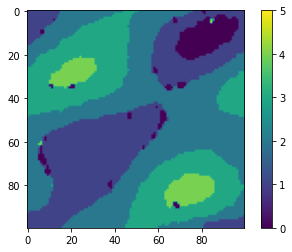

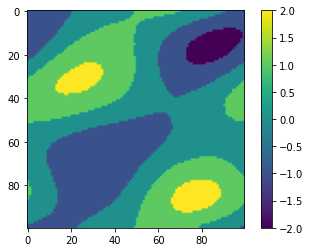

In [178]:
plt.imshow( np.rot90(np.rot90(PredictedVx)) )
plt.colorbar()
plt.show()

plt.imshow( Vx )
plt.colorbar()
plt.show()

In [179]:
np.min(PredictedVx)

0